## Let's Mount Google Drive to save and load files directly from it. We will use it later to save our model to the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Next, we will import required libraries, set up data transformations, download the MNIST dataset, and create a DataLoader to feed images into the model in batches.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)

# Create data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check data shape
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Image batch dimensions: {images.shape}")
print(f"Label batch dimensions: {labels.shape}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.68MB/s]

Image batch dimensions: torch.Size([64, 1, 28, 28])
Label batch dimensions: torch.Size([64])



## Next, we will do three things:

- Define Generator: Define the architecture of the generator model, which transforms random noise into a 28x28 image.

- Define Discriminator: Define the discriminator model architecture, which classifies 28x28 images as real or fake.

- Instantiate Models: Initialize the generator and discriminator models, set up a device (CPU or GPU), and move the models to the selected device.

In [ ]:
import torch.nn as nn

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen(x)
        x = x.view(-1, 1, 28, 28)  # Reshape output to image format
        return x

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image to a vector
        return self.disc(x)

# Instantiate the models
z_dim = 100  # Dimension of the noise vector
G = Generator(z_dim)
D = Discriminator()

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)
D.to(device)

print("Generator architecture:\n", G)
print("\nDiscriminator architecture:\n", D)

Generator architecture:
 Generator(
  (gen): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Discriminator architecture:
 Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (

## Now that we have defined our Discriminator and Generator, the code below does three things:

- Define Training Parameters: Set hyperparameters (learning rate, number of epochs), define the loss function, and create optimizers for the generator and discriminator.

- Training Loop: Implement the training loop for the GAN. Train the discriminator to distinguish real and fake images, and train the generator to create images that the discriminator classifies as real.

- Display Training Progress: Print the discriminator and generator losses at each epoch to monitor training progress.

In [ ]:
import torch.optim as optim

# Hyperparameters
lr = 0.0002
num_epochs = 50  # Adjust as needed for better results

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):

        # Move real images to the device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)  # Flatten

        ### Train Discriminator ###
        D.zero_grad()

        # Real images
        labels_real = torch.ones(batch_size, 1).to(device)
        output_real = D(real_images)
        lossD_real = criterion(output_real, labels_real)

        # Fake images
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(noise)
        labels_fake = torch.zeros(batch_size, 1).to(device)
        output_fake = D(fake_images.detach())  # Detach to avoid training G on these labels
        lossD_fake = criterion(output_fake, labels_fake)

        # Total discriminator loss
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ### Train Generator ###
        G.zero_grad()

        # Generate fake images with flipped labels
        labels_gen = torch.ones(batch_size, 1).to(device)
        output_gen = D(fake_images)
        lossG = criterion(output_gen, labels_gen)

        lossG.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {lossD.item():.4f} | G Loss: {lossG.item():.4f}')

Epoch [1/50] | D Loss: 0.5905 | G Loss: 3.1413
Epoch [2/50] | D Loss: 0.5425 | G Loss: 3.1073
Epoch [3/50] | D Loss: 0.4941 | G Loss: 2.8728
Epoch [4/50] | D Loss: 0.4018 | G Loss: 4.0080
Epoch [5/50] | D Loss: 0.7790 | G Loss: 3.0292
Epoch [6/50] | D Loss: 0.4311 | G Loss: 2.8198
Epoch [7/50] | D Loss: 0.6973 | G Loss: 1.6485
Epoch [8/50] | D Loss: 0.6232 | G Loss: 2.1941
Epoch [9/50] | D Loss: 0.7551 | G Loss: 2.3266
Epoch [10/50] | D Loss: 0.9431 | G Loss: 1.9413
Epoch [11/50] | D Loss: 1.0051 | G Loss: 1.3287
Epoch [12/50] | D Loss: 1.1358 | G Loss: 1.9341
Epoch [13/50] | D Loss: 0.8087 | G Loss: 2.0305
Epoch [14/50] | D Loss: 0.8241 | G Loss: 1.6184
Epoch [15/50] | D Loss: 0.6894 | G Loss: 1.4626
Epoch [16/50] | D Loss: 0.6846 | G Loss: 2.0389
Epoch [17/50] | D Loss: 1.3636 | G Loss: 1.3571
Epoch [18/50] | D Loss: 1.1400 | G Loss: 1.3602
Epoch [19/50] | D Loss: 1.1650 | G Loss: 1.1485
Epoch [20/50] | D Loss: 0.9588 | G Loss: 1.2276
Epoch [21/50] | D Loss: 0.9193 | G Loss: 1.3083
E

## Let's define a function to generate and display images from the trained generator using random noise as input.

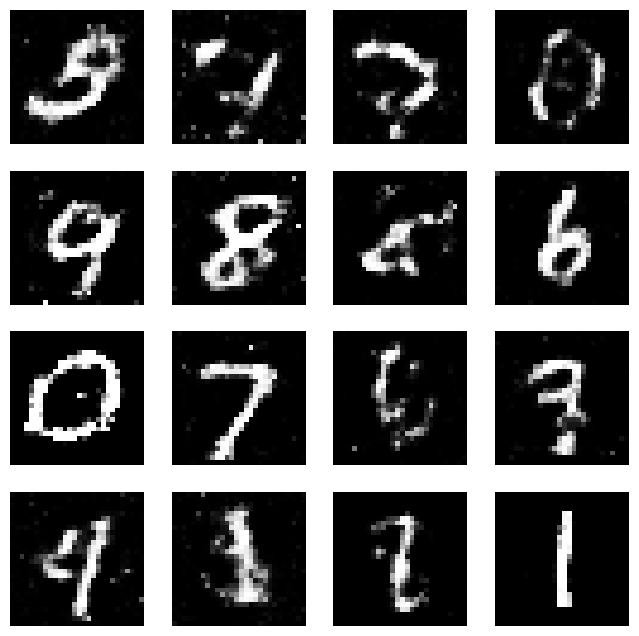

In [ ]:
import matplotlib.pyplot as plt
import torch

# Function to generate and display images from the generator
def generate_images(generator, num_images=16, z_dim=100):
    generator.eval()  # Set the generator to evaluation mode

    # Generate random noise and create images
    noise = torch.randn(num_images, z_dim).to(device)
    with torch.no_grad():
        fake_images = generator(noise)
    fake_images = fake_images.cpu().view(-1, 28, 28)  # Reshape to 28x28

    # Plot generated images in a grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(num_images):
        ax = axes[i // 4, i % 4]
        ax.imshow(fake_images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Generate and visualize images
generate_images(G)


The generated images look recognizable and resemble handwritten digits, which is a good outcome for a simple GAN architecture trained on MNIST. Here’s an analysis of the results:

- Clarity of Digits: Many of the images are clear enough to be identifiable as specific digits. This suggests that the generator has learned basic MNIST characteristics.

- Noise and Artifacts: Some images show slight noise or artifacts, which is typical for simple GANs. The fully connected layers may not capture spatial relationships as effectively as convolutional layers, which could reduce sharpness.

- Diversity: The generator is producing a mix of different digits, indicating that it has learned some variability rather than producing a single digit repeatedly (which can happen with GANs experiencing mode collapse).

Overall, these results demonstrate that the GAN has successfully learned to generate digit-like images, which is impressive given the simple architecture and relatively short training time.



In [ ]:
# Save the generator's state_dict to Google Drive
torch.save(G.state_dict(), '/content/drive/MyDrive/generator_mnist.pth')


In [ ]:
G = Generator(z_dim=100).to(device)
G.load_state_dict(torch.load('/content/drive/MyDrive/generator_mnist.pth'))
G.eval()  # Set to evaluation mode for generating images

Generator(
  (gen): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

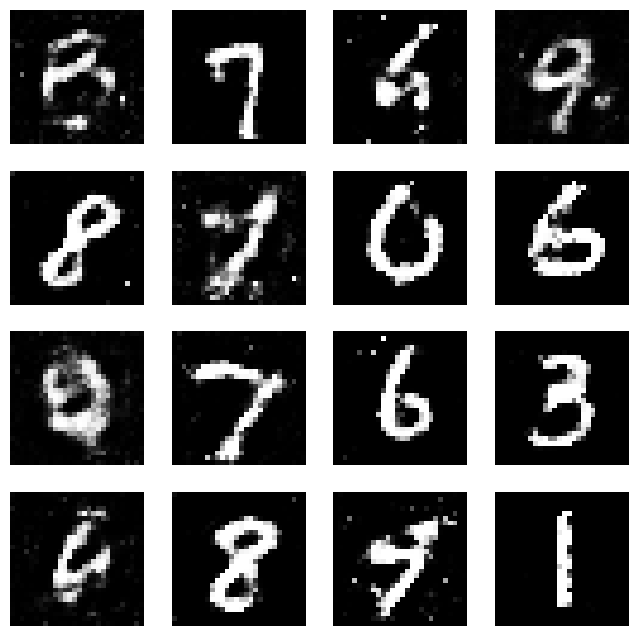

In [ ]:
generate_images(G)

# Improving GAN Stability and Performance

GANs are known for being challenging to train, often suffering from instability, mode collapse, and sensitivity to hyperparameters. Below are some general recommendations to improve GAN stability and achieve better results.

## General Recommendations for Improving GAN Stability and Performance

1. **Use Convolutional Architectures**:
   - Switch from fully connected layers to convolutional layers, especially for image data, to better capture spatial structure and improve image quality.

2. **Add Noise to Training Data**:
   - Adding random noise to real or fake images can help prevent the discriminator from becoming overly confident and improve generalization.

3. **Label Smoothing**:
   - Use "soft" labels for the discriminator (e.g., 0.9 for real images instead of 1.0) to make the discriminator less overconfident, which can stabilize training.

4. **Experiment with Different Latent Space Dimensions**:
   - Increasing or decreasing the noise vector dimension (e.g., 100 to 50 or 200) can impact the diversity and quality of generated images.

5. **Learning Rate Adjustments**:
   - Use a lower learning rate for the generator than the discriminator to help the generator learn more stably and reduce oscillations.

6. **Use Gradient Clipping**:
   - Limit the magnitude of gradients during training to prevent large, destabilizing updates that could harm the model's convergence.

7. **Alternative Loss Functions**:
   - Experiment with different GAN losses (e.g., Wasserstein loss with gradient penalty or Least-Squares GAN loss) to help improve stability and reduce mode collapse.

8. **Add Dropout Layers**:
   - In the discriminator, adding dropout layers can help prevent overfitting, making it harder for the discriminator to be overly confident.

9. **Spectral Normalization**:
   - Apply spectral normalization to the discriminator’s layers to ensure consistent gradient flow, which can improve GAN stability.

10. **Avoid Mode Collapse by Using Mini-batch Discrimination**:
    - A technique where the discriminator looks at the diversity within a batch, encouraging the generator to produce more varied outputs.

---

## Student Experiment Recommendations

In this lab, I recommend you to explore two tasks that enhance GAN performance and stability. These tasks are straightforward to implement but demonstrate the effects of different architectures and hyperparameters on GAN training.

### 1. Experiment with Different Noise Dimensions

   - **Objective**: Explore how changing the dimension of the input noise vector (latent space) affects the diversity and quality of generated images.
   - **Instructions**: Try using different values for the `z_dim` parameter in the generator, such as:
     - **Original**: 100
     - **Smaller**: 50
     - **Larger**: 200
   - **Expected Outcome**:
     - Smaller noise dimensions may lead to less diversity in the generated images, as the generator has less information to work with.
     - Larger noise dimensions can increase diversity, but it may also increase training time or introduce artifacts if the dimension is too large.

### 2. Change the Architecture to a CNN-Based GAN

   - **Objective**: Redesign the generator and discriminator using convolutional layers, creating a CNN-based GAN architecture similar to DCGAN.
   - **Instructions**:
     - Replace fully connected layers in both the generator and discriminator with convolutional (Conv2D) and transposed convolutional (ConvTranspose2D) layers.
     - Use batch normalization and activation functions like ReLU (for generator) and LeakyReLU (for discriminator) to improve gradient flow.
   - **Expected Outcome**:
     - Convolutional architectures can produce more visually appealing and higher-quality images by better capturing the spatial structure of images.
   - **Tips**:
     - In the generator, start with a small spatial size and increase with ConvTranspose2D layers.
     - In the discriminator, start with the full image size and decrease through Conv2D layers, using LeakyReLU activations.

---

These experiments should provide you with hands-on experience in enhancing GAN stability and performance while observing the effects of different architectural choices and hyperparameter tuning. Have fun experimenting and seeing how each change impacts the quality of generated images!
